In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 

# Understanding Relations

![RelationalImage](relation_image.png)

# Time EDA

In [127]:
td = pd.read_csv('data/time_dim.csv')
td['date'] = td['date'].apply(lambda x : pd.to_datetime(x, format='%d-%m-%Y %H:%M'))
ft = pd.read_csv('data/fact_table.csv')

In [128]:
ft['customer_key'] = ft['coustomer_key']
ft = ft.drop(columns = ['coustomer_key'])

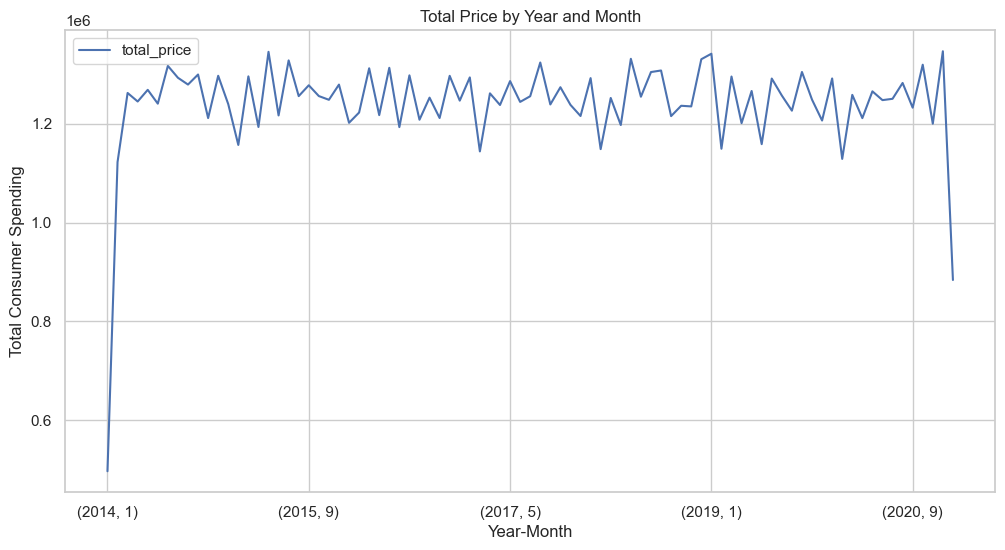

In [129]:
## Let's start with trends in total price per year month
time_fact = ft.merge(td, how = 'inner', left_on= 'time_key', right_on = 'time_key')
trends = time_fact[['year','quarter','month','total_price']].groupby(['year','month'])[['total_price']].sum()
trends.plot(figsize=(12, 6), title='Total Price by Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Consumer Spending')
plt.grid(True)
plt.show()


https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/

In [130]:
## RFM MODEL recency, frequency, and monetary value

rfm_model = (
    time_fact  
    .groupby('customer_key')  
    .agg(
        cust_id=('customer_key', 'first'), 
        purchase_times=('customer_key', 'size'), 
        total_amount=('total_price', 'sum'), 
        recent_sale_date=('date', 'max'),  
        start_sale_date=('date', 'min')  
    )
    .reset_index()  
)

rfm_model['cust_age'] = (rfm_model['recent_sale_date'] - rfm_model['start_sale_date']).dt.days
reference_date = pd.to_datetime('2021-02-01')
rfm_model['day_since_last_visit'] = (reference_date - rfm_model['recent_sale_date']).dt.days
rfm_model.head()

,customer_key,cust_id,purchase_times,total_amount,recent_sale_date,start_sale_date,cust_age,day_since_last_visit
0,C000001,C000001,82,8344.75,2021-01-12 11:41:00,2014-02-06 04:56:00,2532,19
1,C000002,C000002,103,11025.50,2020-11-22 17:48:00,2014-02-28 22:21:00,2458,70
2,C000003,C000003,108,12120.25,2020-11-02 22:31:00,2014-01-24 01:22:00,2474,90
3,C000004,C000004,118,13337.00,2020-12-21 16:50:00,2014-02-14 00:32:00,2502,41
4,C000005,C000005,108,10893.25,2020-11-23 07:07:00,2014-01-22 02:57:00,2497,69


In [131]:
scorerfm_agg = rfm_model.copy()

scorerfm_agg['r_score'] = pd.qcut(scorerfm_agg['day_since_last_visit'], q=5, labels=False, duplicates='drop') + 1
scorerfm_agg['f_score'] = pd.qcut(scorerfm_agg['purchase_times'], q=5, labels=False, duplicates='drop') + 1
scorerfm_agg['m_score'] = pd.qcut(scorerfm_agg['total_amount'], q=5, labels=False, duplicates='drop') + 1

scorerfm_agg.head()

,customer_key,cust_id,purchase_times,total_amount,recent_sale_date,start_sale_date,cust_age,day_since_last_visit,r_score,f_score,m_score
0,C000001,C000001,82,8344.75,2021-01-12 11:41:00,2014-02-06 04:56:00,2532,19,2,1,1
1,C000002,C000002,103,11025.50,2020-11-22 17:48:00,2014-02-28 22:21:00,2458,70,5,2,2
2,C000003,C000003,108,12120.25,2020-11-02 22:31:00,2014-01-24 01:22:00,2474,90,5,3,4
3,C000004,C000004,118,13337.00,2020-12-21 16:50:00,2014-02-14 00:32:00,2502,41,4,4,5
4,C000005,C000005,108,10893.25,2020-11-23 07:07:00,2014-01-22 02:57:00,2497,69,5,3,2


In [132]:
scorerfm_agg['avg_score'] = (scorerfm_agg['f_score'] + scorerfm_agg['m_score']) / 2
scorerfm_agg['status'] = pd.cut(scorerfm_agg['avg_score'], bins=[0, 3, float('inf')], labels=['Low', 'High'], right=False)
def calc_rfm(row): 
      if row['r_score'] >= 3 and row['status'] == 'High':
            return 'Hooked' 
      elif row['r_score'] >= 3 and row['status'] == 'Low':
            return 'Potential_customer'
      elif row['r_score'] < 3 and row['status'] == 'High':
            return 'Can\'t_loose' 
      elif row['r_score'] < 3 and row['status'] == 'Low':
            return 'Lost'
      else: 
            return 'Error'

scorerfm_agg['status'] = scorerfm_agg.apply(calc_rfm, axis=1)
scorerfm_agg[['customer_key', 'cust_age', 'r_score', 'f_score', 'm_score', 'status']]

,customer_key,cust_age,r_score,f_score,m_score,status
0,C000001,2532,2,1,1,Lost
1,C000002,2458,5,2,2,Potential_customer
2,C000003,2474,5,3,4,Hooked
3,C000004,2502,4,4,5,Hooked
4,C000005,2497,5,3,2,Potential_customer
...,...,...,...,...,...,...
9186,C009187,2529,4,3,4,Hooked
9187,C009188,2512,4,4,5,Hooked
9188,C009189,2555,1,4,3,Can't_loose
9189,C009190,2499,5,5,5,Hooked


In [133]:
time_fact.sort_values(by=['customer_key', 'date'], inplace=True)

time_fact['last_time_visit'] = time_fact.groupby('customer_key')['date'].shift(1)
time_fact['day_between_visit'] = (time_fact['date'] - time_fact['last_time_visit']).dt.days

filtered_df = time_fact.dropna(subset=['last_time_visit'])

avg_day_visit = filtered_df.groupby('customer_key')['day_between_visit'].mean().reset_index()
avg_day_visit.rename(columns={'day_between_visit': 'avg_day_visit'}, inplace=True)

avg_day_visit

,customer_key,avg_day_visit
0,C000001,30.777778
1,C000002,23.676471
2,C000003,22.635514
3,C000004,20.905983
4,C000005,22.813084
...,...,...
9186,C009187,22.715596
9187,C009188,20.982906
9188,C009189,22.106195
9189,C009190,19.983607


<AxesSubplot:ylabel='Frequency'>

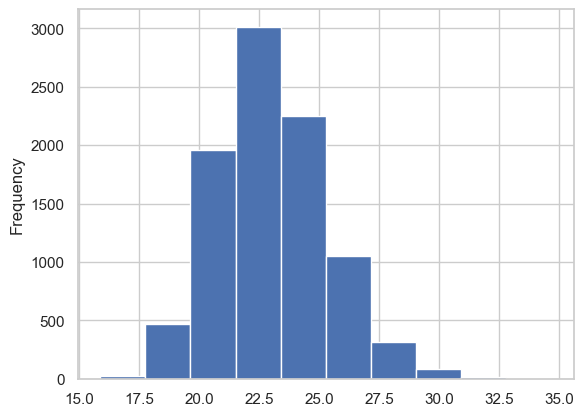

In [134]:
avg_day_visit['avg_day_visit'].plot(kind = 'hist', bins = 10)

In [135]:
ft

,payment_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price,customer_key
0,P026,T049189,I00177,S00307,1,ct,35.0,35.0,C004510
1,P022,T041209,I00248,S00595,1,rolls,26.0,26.0,C008967
2,P030,T03633,I00195,S00496,8,ct,12.5,100.0,C007261
3,P032,T084631,I00131,S0086,8,ct,14.0,112.0,C007048
4,P014,T071276,I00050,S00488,8,cans,8.0,64.0,C006430
...,...,...,...,...,...,...,...,...,...
999995,P010,T09247,I00063,S00502,5,cans,40.0,200.0,C003726
999996,P021,T023483,I00252,S00225,1,ct,11.0,11.0,C002581
999997,P035,T039372,I00119,S00555,7,ct,53.0,371.0,C006133
999998,P031,T097975,I00257,S00440,2,ct,21.0,42.0,C008735


## Stores?

In [136]:
sd = pd.read_csv('data/store_dim.csv')
sd.head()

,store_key,division,district,upazila
0,S0001,SYLHET,HABIGANJ,AJMIRIGANJ
1,S0002,SYLHET,HABIGANJ,BAHUBAL
2,S0003,SYLHET,HABIGANJ,BANIACHONG
3,S0004,SYLHET,HABIGANJ,CHUNARUGHAT
4,S0005,SYLHET,HABIGANJ,HABIGANJ SADAR


In [137]:
store_month = ft.merge(sd, on= 'store_key').merge(td, on = 'time_key')[['division', 'total_price', 'month', 'year']]
total_per_store = store_month.groupby(['month', 'year','division']).sum().reset_index()
total_per_store

,month,year,division,total_price
0,1,2014,BARISAL,35031.50
1,1,2014,CHITTAGONG,94926.00
2,1,2014,DHAKA,192214.25
3,1,2014,KHULNA,54601.00
4,1,2014,RAJSHAHI,55584.50
...,...,...,...,...
590,12,2020,DHAKA,522712.50
591,12,2020,KHULNA,139906.25
592,12,2020,RAJSHAHI,156888.25
593,12,2020,RANGPUR,110664.50


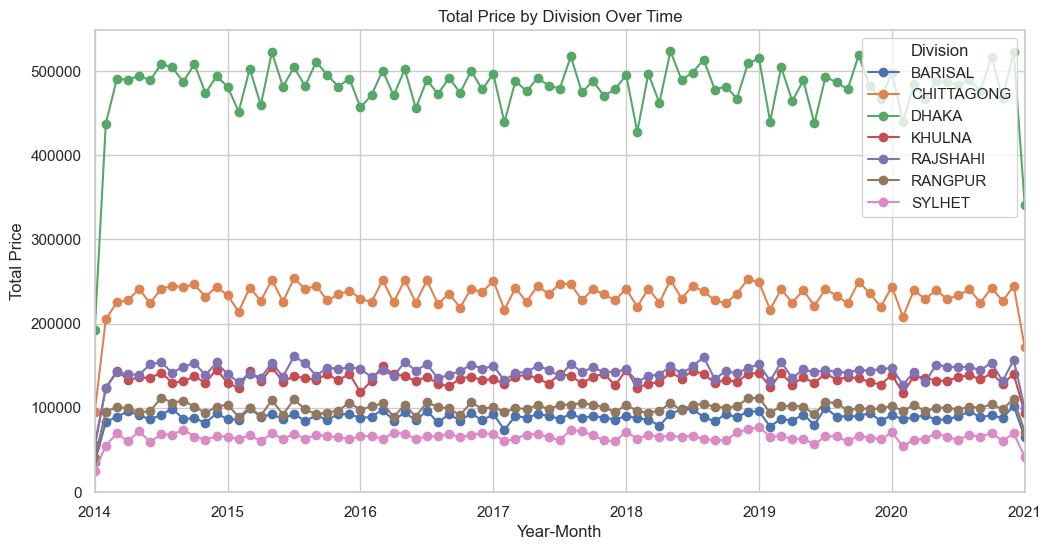

In [138]:
total_per_store['date'] = pd.to_datetime(total_per_store[['year', 'month']].assign(day=1))

pivot_total_per_store = total_per_store.pivot_table(index='date', columns='division', values='total_price', aggfunc='sum')

pivot_total_per_store.plot(figsize=(12, 6), marker='o')
plt.title('Total Price by Division Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Price')
plt.legend(title='Division')
plt.grid(True)
plt.show()

In [139]:
itd = pd.read_csv('data/item_dim.csv')
itd[['item_key', 'item_name', 'desc', 'unit_price']]

,item_key,item_name,desc,unit_price
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75
...,...,...,...,...
259,I00260,Napkins Square Lunch,Kitchen Supplies,15.00
260,I00261,POM 2 ply paper towels,Kitchen Supplies,33.00
261,I00262,Strong Everyday Napkins,Kitchen Supplies,14.00
262,I00263,Advil 2 pill packets,Medicine,14.00


## Try to make a Recommendation System (WE got to make a better one I guess, this doesn't include history of the customer)

https://towardsdatascience.com/recommender-systems-matrix-factorization-using-pytorch-bd52f46aa199 

### Standardize by category probably??? Buying packs and singular values could be messing with the recommendation

In [80]:
favorite_products = ft.groupby('item_key')[['quantity','total_price']].sum().sort_values('quantity', ascending = False)
favorite_products['rating'] = stats.zscore( favorite_products['quantity']) + 2.5003113682852245
favorite_products.head()

,quantity,total_price,rating
item_key,,,
I00015,23969,161790.75,5.370828
I00203,23958,431244.00,5.345385
I00230,23852,357780.00,5.100205
I00023,23802,160663.50,4.984554
I00061,23740,1305700.00,4.841147


In [86]:
ft_utility_matrix = ft[['item_key', 'customer_key', 'quantity']].pivot_table(values = 'quantity', index = 'customer_key', columns = 'item_key', fill_value = 0)
ft_utility_matrix.head()

item_key,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,...,I00255,I00256,I00257,I00258,I00259,I00260,I00261,I00262,I00263,I00264
customer_key,,,,,,,,,,,,,,,,,,,,,
C000001,0.0,5.0,6.5,0.0,8.0,0.0,0.0,0.0,11.0,10.0,...,10.0,2.5,5.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8.0
C000002,4.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.000000,3.000000,11.0
C000003,0.0,6.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,10.0,1.0,0.000000,5.666667,0.0
C000004,3.0,7.0,0.0,6.0,0.0,0.0,0.0,6.5,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,9.0,0.0,5.333333,0.000000,0.0
C000005,11.0,7.0,0.0,7.0,0.0,4.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,9.0,0.0,0.0,7.000000,7.000000,5.0


In [82]:
import sklearn
from sklearn.decomposition import TruncatedSVD

In [83]:
X = ft_utility_matrix.T
X.head()

customer_key,C000001,C000002,C000003,C000004,C000005,C000006,C000007,C000008,C000009,C000010,...,C009182,C009183,C009184,C009185,C009186,C009187,C009188,C009189,C009190,C009191
item_key,,,,,,,,,,,,,,,,,,,,,
I00001,0.0,4.0,0.0,3.0,11.0,0.0,9.0,0.0,0.0,6.0,...,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,2.5,0.0
I00002,5.0,0.0,6.0,7.0,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,5.0,4.0,10.0,0.0,9.0,4.0,0.0,0.0,11.0
I00003,6.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,...,0.0,5.0,8.0,0.0,8.0,11.0,6.0,0.0,7.5,0.0
I00004,0.0,8.0,0.0,6.0,7.0,0.0,0.0,0.0,4.0,0.0,...,7.0,1.0,0.0,0.0,9.0,0.0,7.0,6.0,6.0,0.0
I00005,8.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X.shape

(264, 9191)

In [59]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(264, 10)

In [140]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape
correlation_matrix

array([[1.        , 0.84325782, 0.9160036 , ..., 0.91620279, 0.87777156,
        0.82197684],
       [0.84325782, 1.        , 0.93057889, ..., 0.901158  , 0.94311588,
        0.9705287 ],
       [0.9160036 , 0.93057889, 1.        , ..., 0.91213427, 0.94871404,
        0.90194156],
       ...,
       [0.91620279, 0.901158  , 0.91213427, ..., 1.        , 0.94220546,
        0.8329992 ],
       [0.87777156, 0.94311588, 0.94871404, ..., 0.94220546, 1.        ,
        0.89398841],
       [0.82197684, 0.9705287 , 0.90194156, ..., 0.8329992 , 0.89398841,
        1.        ]])

In [144]:
i = 'I00010'
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

9

In [145]:
correlation_product_ID = correlation_matrix[product_ID]

In [146]:
Recommend = list(X.index[correlation_product_ID > 0.95])
Recommend.remove(i) 
Recommend[0:9]

['I00003',
 'I00006',
 'I00020',
 'I00043',
 'I00064',
 'I00082',
 'I00103',
 'I00108',
 'I00138']

In [149]:
itd.iloc[2]

item_key                              I00003
item_name      Barq's Root Beer - 12 oz cans
desc                      a. Beverage - Soda
unit_price                              6.75
man_country                       Bangladesh
supplier                        DENIMACH LTD
unit                                    cans
Name: 2, dtype: object

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
